In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
from efficient_apriori import apriori
import math

from src import acgraph as acg
from src import utils as ut
from src import xsmining as xsm

In [7]:
def get_degdistrib(g, isbottom = True):

    vidx_to_deg = dict()
    for v in g.vs:
        if v['type'] == isbottom:
            vidx_to_deg[v.index] = v.degree()
    
    degrees = list(vidx_to_deg.values())
    degree_counter = Counter(degrees)
    degree_keys = list(degree_counter.keys())
    counts = list(degree_counter.values())

    #sorting list based on another list
    #https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
    temp = {degkey:count for degkey,count in sorted(zip(degree_keys, counts))}
    deg_ks = list(temp.keys())
    deg_distr = list(temp.values())
    
    return vidx_to_deg, dict(zip(deg_ks,deg_distr))

In [8]:
def get_avecc(g):

    vidx_to_cc = dict()
    
    for v in g.vs:

        #print(v.index)
        neis = g.neighbors(v)
        numneis = len(neis)

        numcp4 = 0
        nump4 = 0

        for idx_a in range(numneis-1):
            va = g.vs[neis[idx_a]]
            neis_a = set(g.neighbors(va))
            neis_a = neis_a - {v.index}

            for idx_b in range(idx_a+1,numneis):
                vb = g.vs[neis[idx_b]]
                neis_b = set(g.neighbors(vb))
                neis_b = neis_b - {v.index}

                numcp4 += len(neis_a & neis_b)
                nump4 += len(neis_a | neis_b)

        if nump4 > 0:
            vidx_to_cc[v.index]=numcp4/nump4
        else:
            vidx_to_cc[v.index]=0
    
    ccs = list(vidx_to_cc.values())
    return sum(ccs)/len(ccs)

In [9]:
def homophily(gur, usrlabel_to_attvals, reslabel_to_attvals):

    hs = 0
    hd = 0

    for i,v in enumerate(gur.vs):
        vidx = v.index

        neigidxs = gur.neighbors(v)
        
        if not v['type']: #Users 
            attvalset = set(usrlabel_to_attvals[v['name']])
        else:
            attvalset = set(reslabel_to_attvals[v['name']])
            
        
        for vidx2 in neigidxs:
            neigidxs2 = gur.neighbors(vidx2)

            for vidx3 in neigidxs2:
                if vidx3 != vidx:
                    v3 = gur.vs[vidx3]
                    if not v3['type']: #Users 
                        attvalset3 = set(usrlabel_to_attvals[v3['name']])
                    else:
                        attvalset3 = set(reslabel_to_attvals[v3['name']])
                    
                    
                    if len(attvalset & attvalset3) > 0:
                        hs += 1
                    else:
                        hd += 1
                        
    return hs/(hs+hd)
                        
                        

In [10]:
import random


def gensyn(gur, usrlabels, reslabels, stop=1):

    random.seed(13)

    usrdegs = []
    resdegs = []
    for v in gur.vs:
        deg = len(gur.neighbors(v['name']))
        if v['type'] == False:
            usrdegs.append(deg)
        else:
            resdegs.append(deg)

    usr_tmpidxs = []
    res_tmpidxs = []
    for i,deg in enumerate(usrdegs):
        for _ in range(deg):
            usr_tmpidxs.append(i)      
    for i,deg in enumerate(resdegs):
        for _ in range(deg):
            res_tmpidxs.append(i+len(usrdegs))
    usr_tmptmpidxs = set(range(len(usr_tmpidxs)))
    res_tmptmpidxs = set(range(len(res_tmpidxs)))
    
    
    edges = set()
    while len(usr_tmptmpidxs)>stop and len(res_tmptmpidxs)>stop:
        idx1 = random.sample(usr_tmptmpidxs, 1)[0]
        idx2 = random.sample(res_tmptmpidxs, 1)[0]
        vidx1 = usr_tmpidxs[idx1]
        vidx2 = res_tmpidxs[idx2]
        #print(len(usr_tmptmpidxs))
    
        if not (vidx1,vidx2) in edges:
            edges.add((vidx1,vidx2))
            usr_tmptmpidxs.remove(idx1)
            res_tmptmpidxs.remove(idx2)

    print(len(edges))
            
    types = []
    for i in range(len(usrlabels)):
        types.append(False)
    for i in range(len(reslabels)):
        types.append(True)
    
    gur_syn = ig.Graph.Bipartite(types=types, edges=list(edges))
    
    ccidx_to_vertexidxs = [cc for cc in gur_syn.clusters()]
    ccidx_to_size = [len(cc) for cc in ccidx_to_vertexidxs]
    max_index = ccidx_to_size.index(max(ccidx_to_size))
    gur_syn2 = gur_syn.induced_subgraph(ccidx_to_vertexidxs[max_index])
    
        
    return gur_syn2

### Load access control graph

In [11]:
usrlabels, usrlabel_to_attvals, usrname_to_usrlabel, \
reslabels, reslabel_to_attvals, resname_to_reslabel, usrlabel_to_reslabel = xsm.load_dataset(name='HC')
print('Num entries:', len(usrlabel_to_reslabel))

Num entries: 1576


In [12]:
usratts = set()
usrtups = list()
for tups in usrlabel_to_attvals.values():
    for tup in tups:
        usratts.add(tup[0])
        usrtups.append(tup)
    
print('Num usr atts:', len(usratts))

for att in usratts:
    usrtups_ = [tup[1] for tup in usrtups if tup[0]==att]
    print('Num att-vals for ' + att + ':', len(set(usrtups_)))
    if att == 'type':
        print(dict(Counter(usrtups_)))
 
resatts = set()
restups = list()
for tups in reslabel_to_attvals.values():
    for tup in tups:
        resatts.add(tup[0])
        restups.append(tup)

print()
print('Num res atts:', len(resatts))

for att in resatts:
    restups_ = [tup[1] for tup in restups if tup[0]==att]
    print('Num att-vals for ' + att + ':', len(set(restups_)))
    

Num usr atts: 6
Num att-vals for position: 2
Num att-vals for specialties: 9
Num att-vals for agentFor: 18
Num att-vals for teams: 20
Num att-vals for type: 4
{'patient': 100, 'agent': 40, 'doctor': 20, 'nurse': 40}
Num att-vals for ward: 10

Num res atts: 6
Num att-vals for author: 176
Num att-vals for topics: 12
Num att-vals for treatingTeam: 20
Num att-vals for patient: 100
Num att-vals for type: 2
Num att-vals for ward: 10


In [13]:
#---Create access control graph---
gur = xsm.load_gur(usrlabels, reslabels, usrlabel_to_reslabel, save=False)
print('Num of users:', len(usrlabels))
print('Num of resources:', len(reslabels))
print('Num of edges:', len(gur.es))

Num of users: 200
Num of resources: 420
Num of edges: 1576


In [14]:
density = len(gur.es)/(len(usrlabels)*len(reslabels))
print('Density:', density)

Density: 0.01876190476190476


In [15]:
ccidx_to_vertexidxs = [cc for cc in gur.connected_components()]
ccidx_to_size = [len(cc) for cc in ccidx_to_vertexidxs]
max_index = ccidx_to_size.index(max(ccidx_to_size))
maxcc_gur = gur.induced_subgraph(ccidx_to_vertexidxs[max_index])
print('CC num vertices:', len(maxcc_gur.vs))

CC num vertices: 620


In [16]:
#Get attribute-values of users
userlog_objs = list(usrlabel_to_attvals.values())

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

In [17]:
import copy
gur2 = copy.deepcopy(gur)

for v in gur.vs:
    if v['type']:
        gur2.vs[v.index]['type'] = 1;
    else:
        gur2.vs[v.index]['type'] = 0;

In [8]:
#gur2.write_gml('hc_acg.gml')

### Small-worldness and homophily

In [18]:
D = gur.shortest_paths()
apl = np.mean(D)
print('average pl:', apl)
print('average cc:', get_avecc(gur))

average pl: 5.479240374609781
average cc: 0.3429730710352203


/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_1395/263104762.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  D = gur.shortest_paths()


In [19]:
gur_syn = gensyn(gur, usrlabels, reslabels)
print('Num of vertices:', len(gur_syn.vs))
print('Num of edges:', len(gur_syn.es))
print('average cc:', get_avecc(gur_syn))

1575
Num of vertices: 620
Num of edges: 1575
average cc: 0.018056266945915302


/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_1395/1236624748.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  idx1 = random.sample(usr_tmptmpidxs, 1)[0]
/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_1395/1236624748.py:32: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  idx2 = random.sample(res_tmptmpidxs, 1)[0]
/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_1395/1236624748.py:52: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  ccidx_to_vertexidxs = [cc for cc in gur_syn.clusters()]


In [20]:
h = homophily(gur, usrlabel_to_attvals, reslabel_to_attvals)
print('Homophily degree:', h)

Homophily degree: 0.8116564788476669


### Resoure degree distribution

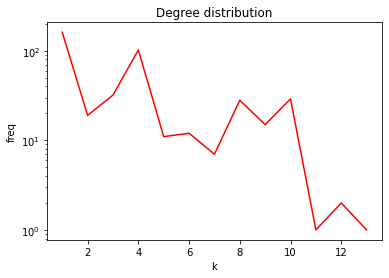

In [9]:
#Degree distribution
vidx_to_deg_res, degs_to_freq = get_degdistrib(gur, isbottom = True)
degs_res = list(degs_to_freq.keys())
count_res = list(degs_to_freq.values())

plt.semilogy(degs_res,count_res,'r-')
plt.title('Degree distribution')
plt.ylabel('freq')
plt.xlabel('k')
plt.show()

In [14]:
x = sum(vidx_to_deg_res.values())/len(vidx_to_deg_res)
print('Avg degree resources:', x)

Avg degree resources: 3.7523809523809524


### User degree distribution

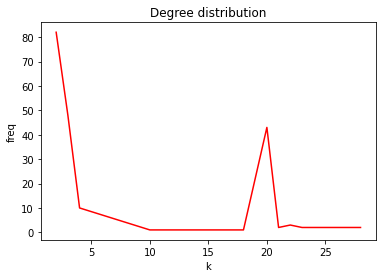

In [15]:
vidx_to_deg_usr, degs_to_count = get_degdistrib(gur, isbottom = False)
degs_usr = list(degs_to_count.keys())
count_usr = list(degs_to_count.values())

plt.plot(degs_usr,count_usr,'r-')
plt.title('Degree distribution')
plt.ylabel('freq')
plt.xlabel('k')
plt.show()

In [16]:
x = sum(vidx_to_deg_usr.values())/len(vidx_to_deg_usr)
print('Avg degree users:', x)

Avg degree users: 7.88
